### Implementações necessárias

In [1]:
# Amostragem iterativa
import cv2
import pandas as pd
        
def coordenadas(Im, Im_Limiarizada, f = 0):  
    
    I = Im.copy()
    I[np.where(Im_Limiarizada == 0)] = 100
    
    # Coordenada [x,y] quando acionado o botão direito
    XY = list() 

    #função armazenará uma coordenada toda vez que o botão direito for acionado
    def direito_down(evento, x, y, flags, params):
        
    # evento igual a 2 quando acionado botão direito
        if evento == 2:            
            ID_class = input("Class ID = ")
        
            if f == 0:
                XY.append([x, y, ID_class])
            else:          
                x = range(x-f, x+f+1)
                y = range(y-f, y+f+1)
                for i in range(0, len(x)):
                    for j in range(0, len(y)):
                        XY.append([x[i], y[j], ID_class]) 
                        
            I[(y-3):(y+3), (x-3):(x+3), :] = 255
    
    # Chamada toda vez que uma tecla do mouse é acionada
    cv2.namedWindow('True Color Image')    
    cv2.setMouseCallback('True Color Image', direito_down)  
    
    while True: 
        cv2.imshow('True Color Image', I)
        k = cv2.waitKey(10) & 0XFF
        if k == cv2.EVENT_RBUTTONDOWN:
            break 
        elif k == ord("q"):
            break
            cv2.waitKey()
            cv2.destroyAllWindows()
            
    cv2.destroyAllWindows()
    
    amostras = pd.DataFrame(XY, columns = ["x", "y", "Class"])    
    
    return amostras

In [2]:
# Função Discriminante 
def FD (X,Mu,C,P):
    X = np.matrix(X)
    I = np.linalg.inv(C)# Inversa da matriz de covariância
    D = np.linalg.det(C)# Determinante da matriz de covariância
    A = X-Mu
    FD = -0.5*A*I*A.transpose()-0.5*np.log(1+D)+np.log(1+P)
    return FD

### Processamento

In [213]:
# Importar dados 
from os import listdir
import numpy as np
import cv2

imagens = listdir("C:/Users/Fernando/Desktop/Artigo - Classificadores/Arroz/")
print imagens

imagem = input("Inserir o indice de posicao da imagem a ser processada = ")
imagem = imagens[imagem]
print imagem

caminho = "C:/Users/Fernando/Desktop/Artigo - Classificadores/Arroz/"+imagem

['Arroz_Amarelado.jpeg', 'Arroz_Casca.jpeg', 'Arroz_Gessado.jpeg', 'Arroz_Normal.jpeg', 'Arroz_Normal_2.jpeg', 'Arroz_Quebrado.jpeg']
Inserir o indice de posicao da imagem a ser processada = 5
Arroz_Quebrado.jpeg


In [214]:
sample = cv2.imread(caminho,1)

#sample = cv2.resize(sample, None,fx=0.35,fy=0.35)

# Recortar área de interesse
#sample = sample[10:910,10:400]

sample_gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

cv2.imshow("sample true color", sample)
cv2.imshow("sample", sample_gray)
cv2.waitKey()
cv2.destroyAllWindows()

In [215]:
#cv2.imwrite("C:/Users/Fernando/Desktop/Artigo - Classificadores/Feijao/Feijao_Vermelho.jpeg", sample)

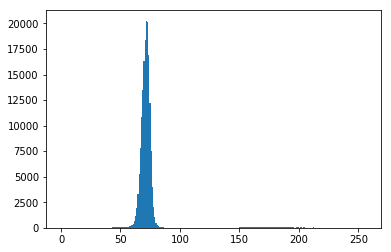

Defina limiar = 100


In [216]:
# Limiarizar imagem
from matplotlib import pyplot as plt

plt.hist(sample_gray.ravel(), 255, [0,256])
plt.show()

threshold = input("Defina limiar = ")

thresh, sample_limiarizada = cv2.threshold(sample_gray, threshold, 255, cv2.THRESH_BINARY_INV)

cv2.imshow("sample limiarizada", sample_limiarizada)
cv2.imshow("sample", sample_gray)
cv2.waitKey()
cv2.destroyAllWindows()

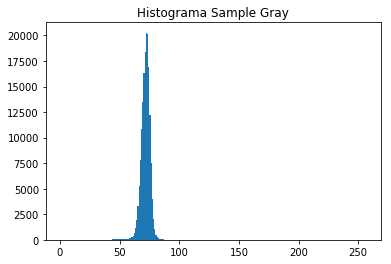

In [217]:
# Avaliar histograma 
sample_gray[np.where(sample_limiarizada == 0)] = 0

plt.hist(sample_gray.ravel(), 255, [1,256])
plt.title("Histograma Sample Gray")
plt.show()

Aplicar logaritmo(0) ou auto-escala(1): 1


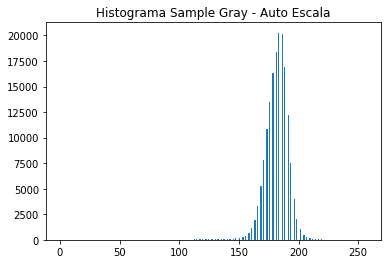

In [218]:
# Aplicar transformacao logaritmo ou auto-escala
transformacao = input("Aplicar logaritmo(0) ou auto-escala(1): ")

if transformacao == 0:
    c = 255/(np.log(1+sample_gray.max()))

    sample_logaritmo = c*np.log(cv2.add(1, sample_gray)) # usa a função cv2.add() pra adicionar 1 na imagem a ser trasformada
    print sample_logaritmo.dtype

    # a transformacao logaritmica não garante valores válidos, dai vc tem que fazer a  autoescala (de 0 a 255)
    sample_logaritmo = ((sample_logaritmo.astype(float) - sample_logaritmo.min())*(255-0))/(sample_logaritmo.max()-sample_logaritmo.min())

    # após a autoescala ainda tem que alterar o tipo de valor
    sample_logaritmo = np.uint8(sample_logaritmo)
    
    plt.hist(sample_logaritmo.ravel(), 255, [1,256])
    plt.title("Histograma Sample Gray - Logaritmo")
    plt.show()

    sample_gray = sample_logaritmo
elif transformacao == 1:
    sample_gray = ((sample_gray.astype(float) - sample_gray.min())*(255-0))/(sample_gray.max()-sample_gray.min())

    plt.hist(sample_gray.ravel(), 255, [1,256])
    plt.title("Histograma Sample Gray - Auto Escala")
    plt.show()

    cv2.imshow("sample limiarizada", sample_limiarizada)
    cv2.imshow("sample autoescala", sample_gray)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [219]:
# Remover ruídos
sample_blur = cv2.medianBlur(sample_limiarizada, 3)

print sample_blur.min()
print sample_blur.max()

cv2.imshow("sample blur", sample_blur)
cv2.waitKey()
cv2.destroyAllWindows()

0
255


In [220]:
# Quantificar objetos (registrar ID's)
sample_contours = sample_blur.copy()
objeto, H = cv2.findContours(sample_contours, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sample_etiquetada = np.zeros((sample.shape[0], sample.shape[1]), np.uint8)

cont = 1

for i in xrange(len(objeto)):
    mask = np.zeros((sample.shape[0], sample.shape[1]), np.uint8)    
    cv2.drawContours(mask, objeto, i, (255,255,255), -1)
    
    sample_etiquetada[np.where(mask != 0)] = cont    
    cont = cont+1
    
    #cv2.imshow("ID %d" %cont, mask)
    #cv2.waitKey()
    #cv2.destroyAllWindows()
    
print "Número de objetos identificados =", len(np.unique(sample_etiquetada[np.where(sample_etiquetada!= 0)]))

Número de objetos identificados = 84


### Cálculo dos Descritores (forma e informações espectrais)

In [221]:
# Criar dataframe para armazenar descritores de forma
ID = range(0,len(objeto))

Descritores_Forma = pd.DataFrame({"ID" : ID, "Perimetro" : 0, "Comprimento" : 0, "Area" : 0, "Fator de Forma" : 0,
                                  "Circularidade" : 0, "Compacidade" : 0, "Excentricidade" : 0,
                                 "Convexidade" : 0, "Solidez" : 0})

Descritores_Forma = Descritores_Forma[["ID", "Perimetro", "Comprimento", "Area", "Fator de Forma", "Circularidade", 
                                       "Compacidade", "Excentricidade", "Convexidade", "Solidez"]]

#Descritores_Forma = pd.DataFrame({"ID" : ID, "Perimetro" : 0, "Comprimento" : 0, "Area" : 0})

#Descritores_Forma = Descritores_Forma[["ID", "Perimetro", "Comprimento", "Area"]]

#print Descritores_Forma

In [222]:
# Calcular descritores de forma
for i in (np.unique(Descritores_Forma.ID)):    
    # Criar uma máscara colorida
    mask = np.zeros((sample.shape[0], sample.shape[1], 3), np.uint8)    
    
    # Desenhar objeto
    cv2.drawContours(mask, objeto, (i), (255,255,255), -1)
    #cv2.imshow("objeto %d" %i, mask)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
    # Calcular os inputs dos descritores:
    # Área
    Area = cv2.contourArea(objeto[i], False)

    # Perímetro
    Perimetro = cv2.arcLength(objeto[i], False)

    # Mínimo Retângulo Envolvente
    Retangulo_Envolvente = cv2.minAreaRect(objeto[i])
    E_maior = max(Retangulo_Envolvente[1])
    E_menor = min(Retangulo_Envolvente[1])

    Box = cv2.cv.BoxPoints(Retangulo_Envolvente)
    Box = np.int0(Box)
    
    Mask_Retangulo_Envolvente = mask.copy()
    cv2.drawContours(Mask_Retangulo_Envolvente, [Box], 0, (255,0,0), 2)  
    
    # Mínimo Círculo Envolvente
    (x,y),Radius = cv2.minEnclosingCircle(objeto[i])
    center = (int(x), int(y))
    radius = int(Radius)

    Mask_Circulo_Envolvente = mask.copy()
    cv2.circle(Mask_Circulo_Envolvente, center, radius, (0,255,0), 2)
    
    # Fecho Convexo
    Fecho = cv2.convexHull(objeto[i])
    Fecho = np.int0(Fecho)
    Perimetro_Convexo = len(Fecho) 
    Area_Convexo = cv2.contourArea(Fecho, False)

    Mask_Fecho = mask.copy()
    cv2.drawContours(Mask_Fecho, [Fecho], 0, (0,0,255), 2)
    
    # Obter os descritores e registrar seus valores
    
    # 0 - Perímetro
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Perimetro"] = Perimetro
    
    # 1 - Comprimento
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Comprimento"] = E_menor
    
    # 2 - Área
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Area"] = Area   
    
    # 3 - Fator de Forma (FF) = (4pi*Area)/(Perimetro)^2
    FF = (4*np.pi*Area)/(Perimetro**2)
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Fator de Forma"] = FF
 
    # 4 - Circularidade = (4*Area)/(pi*(Dc^2))
    Circularidade = (4*Area)/(np.pi*((2*radius)**2))
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Circularidade"] = Circularidade

    # 5 - Compacidade = (Perimetro^2)/(Area)
    Compacidade = (Perimetro**2)/(Area)
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Compacidade"] = Compacidade

    # 6 - Excentricidade = Emaior/Emenor
    Excentricidade = E_maior/E_menor
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Excentricidade"] = Excentricidade

    # 7 - Retangularidade = Area/(L1*L2)
    #Retangularidade = Area/(E_maior*E_menor)
    #Descritores_Forma.loc[Descritores_Forma["Retangularidade"] == (i), "Retangularidade"] = Retangularidade

    # 8 - Convexidade = Pc/Perimetro
    Convexidade = len(Fecho)/Perimetro
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Convexidade"] = Convexidade

    # 9 - Solidez - Area/Ac
    Solidez = Area/Area_Convexo
    Descritores_Forma.loc[Descritores_Forma["ID"] == (i), "Solidez"] = Solidez    
    
    # 10 - Momentos de Hu
    #Momentos = cv2.moments(objeto[i], True)
    
    #Hu_Momentos = cv2.HuMoments(Momentos).flatten()
    
    #cont = 11
    
   # for j in xrange(len(Hu_Momentos)):
    #    Descritores_Forma.iloc[i, j+cont] = Hu_Momentos[j]

    cv2.waitKey()
    cv2.destroyAllWindows()

print Descritores_Forma

    ID    Perimetro  Comprimento      Area  Fator de Forma  Circularidade  \
0    0  1431.000000   296.999939  168399.0        1.033404       0.495220   
1    1     8.071068     2.121320       5.5        1.060988       1.750704   
2    2    19.899495     5.656854      47.0        1.491501       0.598423   
3    3    37.455843     6.871646      87.0        0.779274       0.432703   
4    4    28.970562     7.071068      68.0        1.018134       0.601252   
5    5    23.313708     7.778174      55.0        1.271598       0.700282   
6    6    26.142135     7.000000      52.0        0.956161       0.662085   
7    7    35.556349     7.033533      81.5        0.810090       0.529434   
8    8    32.970562     7.276069      79.5        0.919019       0.516442   
9    9    21.313708     7.000000      39.0        1.078838       1.379343   
10  10    23.313708     7.778174      50.5        1.167558       0.642986   
11  11    26.970562     7.071067      63.5        1.096992       0.808507   

In [223]:
# Criar dataframe para armazenar informações espectrais
ID = range(0, len(objeto))

#Informacoes_Espectrais = pd.DataFrame({"ID" : ID, "Media_R" : 0, "Media_G" : 0, 
#                                       "Media_B" : 0, "Media_Gray" : 0, "Sd_Gray" : 0, 
#                                       "Var_Gray" : 0, "Min_Gray" : 0, "Mediana_Gray" : 0,
#                                       "Max_Gray" :0})

#Informacoes_Espectrais = Informacoes_Espectrais[["ID", "Media_R", "Media_G", "Media_B",
#                                                 "Media_Gray", "Sd_Gray", "Var_Gray",
#                                                 "Min_Gray", "Mediana_Gray", "Max_Gray"]]

Informacoes_Espectrais = pd.DataFrame({"ID" : ID, "Media_R" : 0, "Media_G" : 0, "Media_B" : 0, 
                                       "Media_Gray" : 0,"Media_H" : 0, "Media_S" : 0, "Media_V" : 0})

Informacoes_Espectrais = Informacoes_Espectrais[["ID", "Media_R", "Media_G", "Media_B", 
                                                 "Media_Gray","Media_H", "Media_S", "Media_V"]]


#print Informacoes_Espectrais

In [224]:
# Recuperar informacoes espectrais
#Informacoes = "Media_R", "Media_G", "Media_B", "Media_Gray", "Sd_Gray", "Var_Gray", "Min_Gray", "Mediana_Gray", "Max_Gray"

Informacoes = "Media_R", "Media_G", "Media_B", "Media_Gray", "Media_H", "Media_S", "Media_V"

HSV = cv2.cvtColor(sample, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(HSV)
B, G, R = cv2.split(sample)

for i in xrange(len(objeto)):    
    R = sample[:,:,2]
    R = R[np.where(sample_etiquetada == (i+1))]
    Media_R = np.mean(R)
    
    G = sample[:,:,1]
    G = G[np.where(sample_etiquetada == (i+1))]
    Media_G = np.mean(G)
    
    B = sample[:,:,0]
    B = B[np.where(sample_etiquetada == (i+1))]
    Media_B = np.mean(B)

    Gray = sample_gray[np.where(sample_etiquetada == (i+1))]
    Media_Gray = Gray.mean()
    
    Sd_Gray = Gray.std()
    
    Var_Gray = Gray.var()
    
    #Min_Gray = Gray.min()
    
    Mediana_Gray = np.median(Gray)
    
    #Max_Gray = Gray.max()
    
    H = HSV[:,:,0]
    H = H[np.where(sample_etiquetada == (i+1))]
    Media_H = np.mean(H)
    
    S = HSV[:,:,1]
    S = S[np.where(sample_etiquetada == (i+1))]
    Media_S = np.mean(S)
    
    V = HSV[:,:,2]
    V = V[np.where(sample_etiquetada == (i+1))]
    Media_V = np.mean(V)
    
    #Valores = Media_R, Media_G, Media_B, Media_Gray, Sd_Gray, Var_Gray, Min_Gray, Mediana_Gray, Max_Gray
    Valores = Media_R, Media_G, Media_B, Media_Gray, Media_H, Media_S, Media_V
    
    for j in xrange(len(Valores)):
        Informacoes_Espectrais.loc[Informacoes_Espectrais["ID"] == i, Informacoes[j]] = Valores[j]

#print Informacoes_Espectrais   

In [225]:
# Concatenar descritores e informações
repositorio = pd.concat([Descritores_Forma, Informacoes_Espectrais.loc[:, Informacoes_Espectrais.columns != "ID"]], axis = 1)
print repositorio

    ID    Perimetro  Comprimento      Area  Fator de Forma  Circularidade  \
0    0  1431.000000   296.999939  168399.0        1.033404       0.495220   
1    1     8.071068     2.121320       5.5        1.060988       1.750704   
2    2    19.899495     5.656854      47.0        1.491501       0.598423   
3    3    37.455843     6.871646      87.0        0.779274       0.432703   
4    4    28.970562     7.071068      68.0        1.018134       0.601252   
5    5    23.313708     7.778174      55.0        1.271598       0.700282   
6    6    26.142135     7.000000      52.0        0.956161       0.662085   
7    7    35.556349     7.033533      81.5        0.810090       0.529434   
8    8    32.970562     7.276069      79.5        0.919019       0.516442   
9    9    21.313708     7.000000      39.0        1.078838       1.379343   
10  10    23.313708     7.778174      50.5        1.167558       0.642986   
11  11    26.970562     7.071067      63.5        1.096992       0.808507   

In [226]:
repositorio.to_excel("C:/Users/Fernando/Desktop/Artigo - Classificadores/A_Broken.xlsx")

### Amostragem Iterativa

In [17]:
# Coletar amostras (buffer de amostragem = "f")
dados_aux = coordenadas(sample, sample_limiarizada)
print dados_aux

Class ID = 0
     x    y  Class
0  225  296      0


In [99]:
# Integrar dados aos ID's
amostragem = np.zeros((sample.shape[0], sample.shape[1]), np.uint8)

amostragem[dados_aux.y, dados_aux.x] = 255
cv2.imshow("amostragem", amostragem)

cv2.waitKey()
cv2.destroyAllWindows()
print "ID's amostrados = ", np.unique(sample_etiquetada[dados_aux.y, dados_aux.x]), "\n"

# Tornar compatível indices dos dados_aux e repositório
dados_aux["ID"] = sample_etiquetada[dados_aux.y, dados_aux.x]
indices_compativeis = dados_aux.ID-1
dados_aux = dados_aux.set_index(indices_compativeis)
del dados_aux.index.name

print dados_aux

ID's amostrados =  [ 2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 24 25 26 28 29
 30 31 32 34 35 36 39 40 41 43 44 45 47 48 49 51 52 53 55 57 58 59] 

      x    y  Class  ID
15   79  331      1  16
6    96  419      1   7
1   157  547      1   2
2   222  527      1   3
11  191  383      1  12
5   169  425      1   6
9   211  408      1  10
10  291  399      1  11
4   373  493      1   5
8   346  418      1   9
7   365  412      1   8
52  297   83      1  53
51  365   94      1  52
33  279  189      1  34
12  507  362      1  13
14  383  347      1  15
13  420  351      1  14
47  298  127      1  48
50  509  116      1  51
29  560  215      1  30
46  323  128      1  47
27  462  228      1  28
34  417  183      1  35
28  377  215      1  29
17  379  289      1  18
40  265  155      1  41
57  470   51      1  58
39  437  156      1  40
48  361  115      1  49
56  356   47      1  57
25  335  230      1  26
31  325  194      1  32
35  332  171      1  36
16  393  327      1  1

In [100]:
# Recuperar informações das amostras
for i in xrange(len(dados_aux.ID)):       
    select_i = dados_aux.index[i]
    
    dados_i = dados_aux.loc[ dados_aux["ID"] == (select_i+1), ["Class", "ID"]]  
    
    Descritores_Forma_i = Descritores_Forma.loc[Descritores_Forma["ID"] == (select_i), Descritores_Forma.columns != "ID"]
    
    Informacoes_Espectrais_i = Informacoes_Espectrais.loc[Informacoes_Espectrais["ID"] == (select_i), 
                                                          Informacoes_Espectrais.columns != "ID"]   
    
    dados_i = pd.concat([dados_i, Descritores_Forma_i, Informacoes_Espectrais_i], axis=1)
    
    if i == 0:
        dados = dados_i
    else:
        dados = pd.concat([dados, dados_i], axis = 0)
    
print dados  

    Class  ID  Perimetro  Comprimento   Area  Fator de Forma  Circularidade  \
15      1  16  54.769552     7.717436  144.0        0.603245       0.318310   
6       1   7  42.284271     7.778174  164.0        1.152646       0.362520   
1       1   2  55.355338     8.320503  153.5        0.629505       0.339309   
2       1   3  53.769552     8.310327  169.0        0.734554       0.318310   
11      1  12  59.455844     9.413574  186.0        0.661201       0.350329   
5       1   6  57.870057     8.221920  153.5        0.575984       0.289116   
9       1  10  52.970562     9.000000  177.5        0.794949       0.334320   
10      1  11  59.698484     9.141625  178.5        0.629392       0.336203   
4       1   5  59.556349     8.000000  176.5        0.625314       0.332436   
8       1   9  58.627417     9.000000  179.0        0.654427       0.337145   
7       1   8  51.355338     8.600000  159.0        0.757593       0.418275   
52      1  53  60.012192     9.429904  183.5        

### Exportação de dados

In [101]:
# Exportar dados de treinamento ou validação

import re
amostra = re.split(r'\.(?!\d)', imagem)[0]
amostra = np.int(amostra)
print amostra

chave = input("Definir amostra como 0(Treinamento) ou 1(Validacao):")

if chave == 0:
    dados.to_excel("C:/Users/Fernando/Desktop/Artigo - Classificadores/dados_%d.xlsx" %amostra, index = False)
else:
    dados.to_excel("C:/Users/Fernando/Desktop/Artigo - Classificadores/dados_%d.xlsx" %amostra, index = False)

23
Definir amostra como 0(Treinamento) ou 1(Validacao):0


### Importação de dados de treinamento, cálculo da matriz de covariância, vetores médios e probabilidade de classes

In [63]:
# Importar dados de treinamento 
amostras = listdir("C:/Users/larthur/Desktop/UFV/2_Pos_Graduacao/3_Doutorado/1_Periodo/ENG_639_Processamento_Imagens/5_Trabalho/4_Treinamento/")
treinamento = pd.DataFrame()

for i in xrange(len(amostras)):
    dados_i = pd.read_excel("C:/Users/larthur/Desktop/UFV/2_Pos_Graduacao/3_Doutorado/1_Periodo/ENG_639_Processamento_Imagens/5_Trabalho/4_Treinamento/"+amostras[i])
    
    treinamento = treinamento.append(dados_i, ignore_index = True)

print treinamento

    Class   ID   Perimetro  Comprimento    Area    Media_R    Media_G  \
0       1   81  107.396968    28.284269   818.0  42.283237  71.763006   
1       1   56   91.669047    25.491173   622.5  34.260542  62.114458   
2       1   33   84.355338    24.000000   635.5  47.771723  77.455081   
3       1   14   85.083261    22.469135   574.0  41.120521  71.951140   
4       1   22   91.083260    28.493500   671.0  42.777311  71.931373   
5       1   62   95.982755    24.129461   683.5  40.700138  72.126547   
6       1   27   86.911687    24.129461   591.0  47.339144  78.375594   
7       1   25   73.355338    20.000000   448.5  42.936082  75.956701   
8       2   23   60.698484    19.000000   310.5  28.855882  44.291176   
9       2   79   84.012193    25.000000   572.5  31.497553  48.778140   
10      1   54  185.509666    34.811413  1262.0  38.961338  66.000000   
11      1   37  237.693432    48.415470  1589.5  41.824675  70.559622   
12      1   51   83.769552    23.000000   565.0  44

In [64]:
# Calcular probabilidade de cada classe
treinamento_length = treinamento.shape[0]
Probabilidades = list()

for i in np.unique(treinamento.Class):
    class_i = treinamento.loc[treinamento["Class"] == i,"Class"]
    class_i = len(class_i)
    
    prob_i = class_i/float(treinamento_length)
    
    Probabilidades.insert(i, prob_i)
    
#Probabilidades = [0.33, 0.33, 0.33]
print Probabilidades

[0.6451612903225806, 0.3548387096774194]


In [65]:
# Separar conjunto de treinamento para cada defeito
treinamento_classe = list()

for i in np.unique(treinamento.Class):    
    treinamento_classe_i = treinamento.loc[treinamento["Class"] == i, :] 
    treinamento_classe_i = treinamento_classe_i.iloc[:,treinamento_classe_i.columns != "ID"]
    
    treinamento_classe.insert(i, treinamento_classe_i)    
    
print treinamento_classe

[    Class   Perimetro  Comprimento    Area    Media_R    Media_G     Media_B  \
0       1  107.396968    28.284269   818.0  42.283237  71.763006   99.878613   
1       1   91.669047    25.491173   622.5  34.260542  62.114458   94.234940   
2       1   84.355338    24.000000   635.5  47.771723  77.455081  107.160530   
3       1   85.083261    22.469135   574.0  41.120521  71.951140  104.100977   
4       1   91.083260    28.493500   671.0  42.777311  71.931373   99.117647   
5       1   95.982755    24.129461   683.5  40.700138  72.126547  102.515818   
6       1   86.911687    24.129461   591.0  47.339144  78.375594  107.683043   
7       1   73.355338    20.000000   448.5  42.936082  75.956701  110.321649   
10      1  185.509666    34.811413  1262.0  38.961338  66.000000   94.952416   
11      1  237.693432    48.415470  1589.5  41.824675  70.559622  100.805785   
12      1   83.769552    23.000000   565.0  44.366337  76.539604  109.037954   
13      1   97.083260    30.000000   73

In [66]:
# Gerar matrizes de covariancia e vetores medios com dados de treinamento
# Classes: normais, quebrados, pretos + verdes, cascas
Cov_Matrix = list()
Vetor_Medio = list()

for i in xrange(len(treinamento_classe)):
    treinamento_classe_i = treinamento_classe[i]     
    treinamento_classe_i = pd.DataFrame(treinamento_classe_i)
    treinamento_classe_i = treinamento_classe_i.loc[:, treinamento_classe_i.columns != "Class"]
    treinamento_classe_i = treinamento_classe_i.T
    #print treinamento_classe_i, "\n"  
    
    treinamento_classe_i = treinamento_classe_i.as_matrix()
    #print treinamento_classe_i, "\n"
        
    Cov_Matrix_i = np.cov(treinamento_classe_i)
    #print Cov_Matrix_i, "\n"
    Cov_Matrix.insert(i, Cov_Matrix_i)
    
    Vetor_Medio_i = np.average(treinamento_classe_i,1)# Vetor médio
    #print Vetor_Medio_i, "\n"
    
    Vetor_Medio.insert(i, Vetor_Medio_i)

#print Cov_Matrix[0], "\n"
#print Vetor_Medio[0], "\n"

### Importação de dados a serem classificados

In [67]:
# Importar dados de validacao
amostras = listdir("C:/Users/larthur/Desktop/UFV/2_Pos_Graduacao/3_Doutorado/1_Periodo/ENG_639_Processamento_Imagens/5_Trabalho/5_Validacao/")
validacao = pd.DataFrame()

for i in xrange(len(amostras)):
    validacao_i = pd.read_excel("C:/Users/larthur/Desktop/UFV/2_Pos_Graduacao/3_Doutorado/1_Periodo/ENG_639_Processamento_Imagens/5_Trabalho/5_Validacao/"+amostras[i])
    
    validacao = validacao.append(validacao_i, ignore_index = True)
    
print validacao

   Class  ID   Perimetro  Comprimento    Area    Media_R    Media_G  \
0      2  57   72.941125    20.000000   451.0  27.320329  44.045175   
1      2  53  134.710677    24.228725   762.0  36.920925  58.475669   
2      1  50   72.355339    21.000000   433.5  38.174840  69.272921   
3      1  42  156.953317    31.201988  1090.5  37.141874  62.877042   
4      1  65  190.166521    35.217392  1486.0  44.300446  74.756206   

      Media_B  Media_Gray  
0   63.827515  201.414784  
1   84.338200  214.307786  
2  106.722814  227.481876  
3   93.958727  221.206363  
4  105.786760  229.199236  


In [68]:
# Separar conjunto de validacao para cada defeito
validacao_classe = list()
ID = list()

for i in np.unique(validacao.Class):    
    validacao_classe_i = validacao.loc[validacao["Class"] == i, :] 
    validacao_classe_i = validacao_classe_i.reset_index(drop=True)
    #print validacao_classe_i
    
    ID_i = validacao_classe_i.loc[:,"ID"]
    ID.insert(i, ID_i)
    
    validacao_classe_i = validacao_classe_i.iloc[:,validacao_classe_i.columns != "ID"]    
    validacao_classe.insert(i, validacao_classe_i)
       
#print validacao_classe
#print ID

In [69]:
# Processar matriz de validacao para adequar a FD
Matrix_Validacao = list()

for i in xrange(len(validacao_classe)):
    validacao_classe_i = validacao_classe[i]     
    validacao_classe_i = pd.DataFrame(validacao_classe_i)
    validacao_classe_i = validacao_classe_i.loc[:, validacao_classe_i.columns != "Class"]
    validacao_classe_i = validacao_classe_i.T
    #print validacao_classe_i, "\n"  
    
    validacao_classe_i = validacao_classe_i.as_matrix()
    #print matrix_classe_i, "\n"    
    
    Matrix_Validacao.insert(i, validacao_classe_i)
    
#print Matrix_Validacao

In [70]:
# Criar um repositório para resultado da classificacao
Classificacao = pd.DataFrame({"Class" : validacao.Class, "ID" : validacao.ID})

for i in np.unique(validacao.Class):
    class_i = [0]*len(validacao.Class)
    Classificacao_i = pd.DataFrame({"%d" %i : class_i})
    
    Classificacao = pd.concat([Classificacao, Classificacao_i], axis=1)

print Classificacao

   Class  ID  1  2
0      2  57  0  0
1      2  53  0  0
2      1  50  0  0
3      1  42  0  0
4      1  65  0  0


### Aplicação do classificador

In [71]:
# Aplicar classificar nas imagens de validacao   
for i in xrange(len(Matrix_Validacao)): # i define a matriz de validacao das classes
    
    Matrix_Validacao_i = Matrix_Validacao[i]
    
    for j in xrange(len(Vetor_Medio)): # j define as classes de defeitos
        
        Vetor_Medio_j = Vetor_Medio[j]        
        Cov_Matrix_j = Cov_Matrix[j]
        Probabilidades_j = Probabilidades[j]    
        
        for k in range(0,Matrix_Validacao_i.shape[1]): # k define o objeto que está sendo classificado na matriz i
            FD_ij = FD(Matrix_Validacao_i[:,k], Vetor_Medio_j, Cov_Matrix_j, Probabilidades_j)  
            
            ID_i = ID[i][k]
            
            coluna = str(j+1)           
            
            Classificacao.loc[Classificacao["ID"] == ID_i, Classificacao.columns == coluna] = FD_ij
            
            #if k == 0:
                #print "ID = ", ID_i 
                #print "Matriz validacao = ", i+1
                #print "Classe = ", j+1
                #print FD_ij
            
                #print Classificacao, "\n"

print Classificacao    

   Class  ID           1           2
0      2  57 -222.837691  -14.201281
1      2  53 -121.684230  -15.839655
2      1  50  -15.660144 -388.921798
3      1  42  -13.669898 -107.114942
4      1  65  -33.923991 -582.654024


In [72]:
# Adicionar uma coluna no objeto classificacao com a classe final dos objetos
for i in xrange(Classificacao.shape[0]):    
    valores_i = Classificacao.iloc[i, 2:(len(Classificacao))]
    Classificacao.loc[i, "Classe"] = valores_i.idxmax()
    
print Classificacao

   Class  ID           1           2 Classe
0      2  57 -222.837691  -14.201281      2
1      2  53 -121.684230  -15.839655      2
2      1  50  -15.660144 -388.921798      1
3      1  42  -13.669898 -107.114942      1
4      1  65  -33.923991 -582.654024      1


In [73]:
# Criar a matriz de confusao
Matriz_Confusao = pd.DataFrame({"Classe" : np.append(np.unique(Classificacao.Class), ["Total", "Acuracia Classificador", "EO"], axis=0)})

for i in np.unique(Classificacao.Class):
    Matriz_Confusao[str(i)] = 0   
    
Matriz_Confusao["Total"] = 0
Matriz_Confusao["Acuracia Usuario"] = 0
Matriz_Confusao["EC"] = 0

print Matriz_Confusao

                   Classe  1  2  Total  Acuracia Usuario  EC
0                       1  0  0      0                 0   0
1                       2  0  0      0                 0   0
2                   Total  0  0      0                 0   0
3  Acuracia Classificador  0  0      0                 0   0
4                      EO  0  0      0                 0   0


In [74]:
# Computar a matriz de confusao

for i in np.unique(Classificacao.Class):
    amostras = len(Classificacao.Class[Classificacao.Class == i])
    amostras_classificadas = len(Classificacao.Classe[Classificacao.Classe == str(i)])
    
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "Total", str(i)] = amostras
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), "Total"] = amostras_classificadas
    
    for j in np.unique(Classificacao.Classe):        
        amostras_i = Classificacao.loc[Classificacao["Class"] == i, "Classe"]
        teste = amostras_i[amostras_i == str(j)]
        amostras_ij = teste.count()
        Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), str(j)] = amostras_ij
        #print i
        #print j
        #print amostras_ij
        #print Matriz_Confusao
        
print Matriz_Confusao

                   Classe  1  2  Total  Acuracia Usuario  EC
0                       1  3  0      3                 0   0
1                       2  0  2      2                 0   0
2                   Total  3  2      0                 0   0
3  Acuracia Classificador  0  0      0                 0   0
4                      EO  0  0      0                 0   0


In [75]:
# Calcular exatidao global, acuracias, erros de omissao e comissao
N = np.sum(Matriz_Confusao.Total)

for i in np.unique(Classificacao.Class):    
    amostras_ii = Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), str(i)]     
    contador_ii = amostras_ii.values
    
    # Acuracia do classificador para classe "i"
    total_i = Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "Total", str(i)]
    acuracia_classificador_i = contador_ii/total_i*100
    acuracia_classificador_i = acuracia_classificador_i.values
    
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "Acuracia Classificador", str(i)] = acuracia_classificador_i
    
    # Acuracia do usuario para a classe "i"
    total_j = Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), "Total"]
    acuracia_usuario_i = contador_ii/total_j*100
    acuracia_usuario_i = acuracia_usuario_i.values
    
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), "Acuracia Usuario"] = acuracia_usuario_i
    
    # Erros de omissao
    EO = 100 - acuracia_classificador_i
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "EO", str(i)] = EO
    
    # Erros de comissao
    EC = 100 - acuracia_usuario_i
    Matriz_Confusao.loc[Matriz_Confusao["Classe"] == str(i), "EC"] = EC
    
    if i == 1:
        contador = contador_ii
    else:
        contador = contador + contador_ii
        

#Matriz_Confusao.loc[Matriz_Confusao["Classe"] == "Total", "Total"] = contador/N*100
print Matriz_Confusao

                   Classe      1      2  Total  Acuracia Usuario   EC
0                       1    3.0    0.0      3             100.0  0.0
1                       2    0.0    2.0      2             100.0  0.0
2                   Total    3.0    2.0      0               0.0  0.0
3  Acuracia Classificador  100.0  100.0      0               0.0  0.0
4                      EO    0.0    0.0      0               0.0  0.0


In [76]:
# Calcular kappa
kappa_aux = Matriz_Confusao.iloc[0:3,1:4]
kappa_aux = kappa_aux.as_matrix()
vetor_amostras = kappa_aux[kappa_aux.shape[0]-1,:]
vetor_classificadas = kappa_aux[:,kappa_aux.shape[1]-1]

N_diagonal = np.sum(N*kappa_aux.diagonal())
produto = np.sum(vetor_amostras*vetor_classificadas)

kappa = (N_diagonal - produto)/((N**2) - produto)

print kappa

1.0


### Representação dos resultados

In [123]:
# Mostrar amostras antes da classificacao
r = [255,0,0]
g = [0,255,0]
b = [0,0,255]

mask = np.zeros((sample.shape[0], sample.shape[1], 3), np.uint8)
amostras_originais = mask.copy()

for i in np.unique(Classificacao.Class):
    ID_class_i = Classificacao.loc[Classificacao["Class"] == i, "ID"]
    ID_class_i = np.array(ID_class_i)
    
    for j in xrange(len(ID_class_i)):        
        amostras_originais[np.where(sample_etiquetada == ID_class_i[j]-1)] = r[i], g[i], b[i]

In [143]:
# Mostrar amostras classificadas
r = [255,0,0]
g = [0,255,0]
b = [0,0,255]

mask = np.zeros((sample.shape[0], sample.shape[1], 3), np.uint8)
amostras_classificadas = mask.copy()

print Classificacao

for i in np.unique(Classificacao.Classe):
    ID_classe_i = Classificacao.loc[Classificacao["Classe"] == str(i), "ID"]
    ID_classe_i = np.array(ID_classe_i)
    
    for j in xrange(len(ID_classe_i)): 
        amostras_classificadas[np.where(sample_etiquetada == ID_classe_i[j]-1)] = r[int(i)], g[int(i)], b[int(i)]

   Class  ID           1           2 Classe
0      2  57 -222.837691  -14.201281      2
1      2  53 -121.684230  -15.839655      2
2      1  50  -15.660144 -388.921798      1
3      1  42  -13.669898 -107.114942      1
4      1  65  -33.923991 -582.654024      1


In [144]:
cv2.imshow("Amostras Originais", amostras_originais)
cv2.imshow("Amostras Classificadas", amostras_classificadas)
cv2.waitKey()
cv2.destroyAllWindows()   